In [33]:
import os
import warnings

import yaml
from sklearn.dummy import DummyClassifier
import pandas as pd
import numpy as np
# import xgboost as xgb
# import lightgbm as lgb
from catboost import CatBoostClassifier

# from sklearn.impute import KNNImputer
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import Normalizer, FunctionTransformer, RobustScaler
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest, shapiro, probplot
import category_encoders as ce
import mlflow
import os
import logging
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from alive_progress import alive_bar
import time

In [39]:
with alive_bar(1000, force_tty=True, title='Test', bar='filling', spinner='waves') as bar:
    bar.text("Loading data")
    for i in range(1000):
        time.sleep(.005)
        if i and i % 300 == 0:
            print('cool!')
        bar()

on 300: cool!                                                                   
on 600: cool!                                                                   
on 900: cool!                                                                   
Test |████████████████████████████████████████| 1000/1000 [100%] in 6.2s (161.99


In [11]:
train_data = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/train_set_01_processed.parquet.gzip"
)
# test_data = pd.read_parquet('../data/processed/firefox/08_12_2022/test_set_01_processed.parquet.gzip')
# test_data = pd.read_parquet('../data/processed/brave/08_12_2022/test_set_all_processed.parquet.gzip')

test_data = pd.read_parquet('../data/processed/chrome/03_29_2023/merged_data_processed.parquet.gzip')

In [40]:
train_data = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/train_set_01_featurized_BE.parquet.gzip"
)
# test_data = pd.read_parquet('../data/processed/firefox/08_12_2022/test_set_01_processed.parquet.gzip')
# test_data = pd.read_parquet('../data/processed/brave/08_12_2022/test_set_all_processed.parquet.gzip')

test_data = pd.read_parquet('../data/processed/chrome/03_29_2023/merged_data_featurized_BE.parquet.gzip')

In [41]:
len(train_data) / (2 * np.bincount(train_data['tracker']))

array([0.69857462, 1.75897257])

In [6]:
train_data

,comb_col_non_tracker,comb_col_tracker,pragma_binary,content-type_binary,last-modified_binary,accept-ranges_binary,etag_binary,p3p_binary,x-xss-protection_binary,x-content-type-options_binary,...,x-amz-meta-codebuild-content-md5_binary,x-llid_binary,x-b3-sampled_binary,x-b3-spanid_binary,x-hubspot-correlation-id_binary,x-hs-target-asset_binary,x-hostname_binary,x-cdn-pop_binary,x-cdn-pop-ip_binary,tracker
0,0,0,0,1,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
1,2,0,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1
3,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271999,5,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
272000,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
272001,0,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
272002,1,0,0,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [7]:
test_data

,comb_col_non_tracker,comb_col_tracker,pragma_binary,content-type_binary,last-modified_binary,accept-ranges_binary,etag_binary,p3p_binary,x-xss-protection_binary,x-content-type-options_binary,...,x-amz-meta-codebuild-content-md5_binary,x-llid_binary,x-b3-sampled_binary,x-b3-spanid_binary,x-hubspot-correlation-id_binary,x-hs-target-asset_binary,x-hostname_binary,x-cdn-pop_binary,x-cdn-pop-ip_binary,tracker
0,0,0,1,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,1,1,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,1,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802808,0,0,1,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
802809,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
802810,0,0,1,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
802811,0,0,1,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [84]:
# del train_data['comb_col_tracker']
# del train_data['comb_col_non_tracker']
#
# del test_data['comb_col_tracker']
# del test_data['comb_col_non_tracker']

In [43]:
def calculate_metrics(data, y_true):
    y_pred = clf.predict(data)
    pred_probs = clf.predict_proba(data)
    score = metrics.log_loss(y_true, pred_probs)
    auc_score = metrics.roc_auc_score(y_true, y_pred)
    f1_score = metrics.f1_score(y_true, y_pred)
    bal_acc = metrics.balanced_accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    mcc = metrics.matthews_corrcoef(y_true, y_pred)

    print(
        "Model accuracy score : {0:0.4f}".format(metrics.accuracy_score(y_test, y_pred))
    )
    print("Balanced accuracy score : {0:0.4f}".format(bal_acc))
    print("F1 score : {0:0.4f}".format(f1_score))
    print("Model log-loss score : {0:0.4f}".format(score))
    print("Matthews correlation coefficient score : {0:0.4f}".format(mcc))
    print("Precision score : {0:0.4f}".format(precision))
    print("Recall score : {0:0.4f}".format(recall))
    print("Model auc score : {0:0.4f}".format(auc_score))

    print(metrics.classification_report(y_test, y_pred))

    disp_1 = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    disp_2 = metrics.PrecisionRecallDisplay.from_estimator(
        clf, X_test, y_test, name="Random Forest"
    )
    disp_3 = metrics.RocCurveDisplay.from_estimator(clf, X_test, y_test)
    # mlflow.log_figure(disp_1.figure_, "cm.png")
    # mlflow.log_figure(disp_2.figure_, "prec_recall.png")
    # mlflow.log_figure(disp_3.figure_, "roc.png")

In [41]:
train_data = train_data[~train_data.iloc[:, :-1].duplicated(keep="first")].reset_index(drop=True)
test_data = test_data[~test_data.iloc[:, :-1].duplicated(keep="first")].reset_index(drop=True)

In [42]:
X_train, y_train = train_data.iloc[:, :-1], train_data[["tracker"]]
X_test, y_test = test_data.iloc[:, :-1], test_data[["tracker"]]

del train_data
del test_data

In [24]:
clf = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=10,
    criterion="log_loss",
    max_features=None,
)

# clf = DecisionTreeClassifier()
# clf = GradientBoostingClassifier()
# clf = xgb.XGBClassifier()
# clf = lgb.LGBMClassifier(class_weight="balanced")
# clf = MLPClassifier()
# clf = LogisticRegression(n_jobs=-1, random_state=10)
# clf = GaussianNB()

In [3]:
# logging.basicConfig(level=logging.WARN)
# logger = logging.getLogger(__name__)
# warnings.filterwarnings("ignore")
#
# with open("../params.yaml", "rb") as f:
#     params = yaml.safe_load(f)
#
# mlflow.set_tracking_uri(params["ml_flow"]["MLFLOW_TRACKING_URI"])
# os.environ["MLFLOW_TRACKING_USERNAME"] = params["ml_flow"][
#     "MLFLOW_TRACKING_USERNAME"
# ]
# os.environ["MLFLOW_TRACKING_PASSWORD"] = params["ml_flow"][
#     "MLFLOW_TRACKING_PASSWORD"
# ]
#
# mlflow.set_experiment("all_binary_firefox_experiments")
# mlflow.sklearn.autolog()
# mlflow.xgboost.autolog()
# mlflow.lightgbm.autolog()

In [ ]:
# logged_model = 'runs:/c210d5dc13a641f68fd5feff177ebe8b/model'
# # Load model as a PyFuncModel.
# loaded_model = mlflow.pyfunc.load_model(logged_model)

Model accuracy score : 0.9238
Balanced accuracy score : 0.9035
F1 score : 0.8535
Model log-loss score : 0.4956
Matthews correlation coefficient score : 0.8021
Precision score : 0.8456
Recall score : 0.8616
Model auc score : 0.9035
              precision    recall  f1-score   support

           0       0.95      0.95      0.95    596066
           1       0.85      0.86      0.85    206747

    accuracy                           0.92    802813
   macro avg       0.90      0.90      0.90    802813
weighted avg       0.92      0.92      0.92    802813



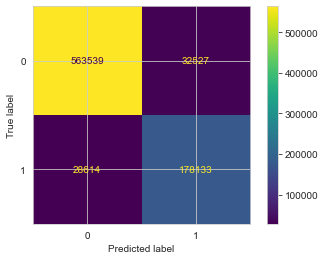

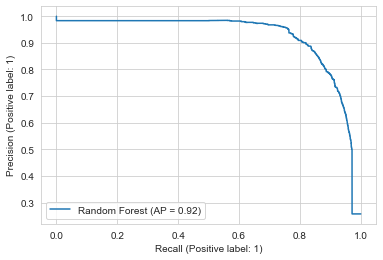

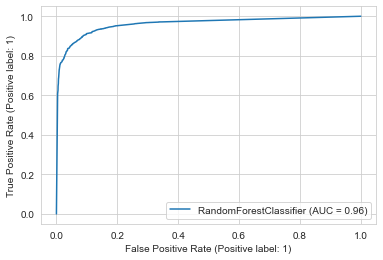

In [25]:
clf.fit(X_train, y_train["tracker"])
calculate_metrics(X_test, y_test)

\footnote{. \url{}, [Accessed Jan. 31, 2023]}

In [10]:
# from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from typing import Dict, List, Tuple
from sklearn.model_selection import StratifiedKFold
from sklearn.base import BaseEstimator

In [46]:
models = {
        "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=10, criterion="gini",
                                                max_features=None),
        # "KNN": KNeighborsClassifier(n_jobs=-1),
        "Decision Tree": DecisionTreeClassifier(random_state=10),
        "Gradient Boosting": GradientBoostingClassifier(random_state=10),
        "Hist Gradient Boosting": HistGradientBoostingClassifier(
                random_state=10, class_weight="balanced"
            ),
        # "XGBoost": XGBClassifier(random_state=10, use_label_encoder=False, eval_metric="logloss"),
        # "LightGBM": LGBMClassifier(random_state=10, class_weight="balanced"),
        # "CatBoost": CatBoostClassifier(random_state=10, verbose=0),
        # "MLP": MLPClassifier(random_state=10),
        "Logistic Regression": LogisticRegression(random_state=10),
        "Gaussian NB": GaussianNB()
    }

In [47]:
from typing import Dict, List, Tuple

In [48]:
def calculate_metrics(
    y_true: pd.Series, y_pred: np.ndarray, y_pred_proba: np.ndarray
) -> Dict[str, float]:
    score = metrics.log_loss(y_true, y_pred_proba)
    auc_score = metrics.roc_auc_score(y_true, y_pred)
    f1_score = metrics.f1_score(y_true, y_pred)
    bal_acc = metrics.balanced_accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    mcc = metrics.matthews_corrcoef(y_true, y_pred)

    # TODO: Add more metrics here.
    # print(metrics.classification_report(y_test, y_pred))
    #
    # disp_1 = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    # disp_2 = metrics.PrecisionRecallDisplay.from_estimator(
    #     clf, X_test, y_test, name="Random Forest"
    # )
    # disp_3 = metrics.RocCurveDisplay.from_estimator(clf, X_test, y_test)
    # mlflow.log_figure(disp_1.figure_, "cm.png")
    # mlflow.log_figure(disp_2.figure_, "prec_recall.png")
    # mlflow.log_figure(disp_3.figure_, "roc.png")

    return {
        "accuracy": metrics.accuracy_score(y_true, y_pred),
        "log_loss": score,
        "auc": auc_score,
        "balanced_accuracy": bal_acc,
        "f1": f1_score,
        "precision": precision,
        "recall": recall,
        "mcc": mcc,
    }

In [60]:
# def perform_cross_validation(
#     X: pd.DataFrame, y: pd.Series, clf: Pipeline, cv: StratifiedKFold
# ) -> List[Dict[str, float]]:
#     all_metrics = []
#
#     for train_idx, test_idx in cv.split(X, y):
#         X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
#         X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
#
#         clf.fit(X_train, y_train)
#         y_pred = clf.predict(X_test)
#         y_pred_proba = clf.predict_proba(X_test)[:, 1]
#
#         fold_metrics = calculate_metrics(y_test, y_pred, y_pred_proba)
#         all_metrics.append(fold_metrics)
#
#     return all_metrics
#
#
# def mean_metrics(all_metrics: List[Dict[str, float]]) -> Dict[str, float]:
#     return {
#         metric: np.mean([fold_metrics[metric] for fold_metrics in all_metrics])
#         for metric in all_metrics[0].keys()
#     }

In [65]:
# def train_and_evaluate_models(
#     models: Dict[str, BaseEstimator],
#     X: pd.DataFrame,
#     y: pd.Series,
#     cv: StratifiedKFold,
#     # preprocessor: ColumnTransformer,
# ) -> pd.DataFrame:
#     all_mean_metrics = {}
#
#     for model_name, model in models.items():
#         print(f"Training and evaluating {model_name}...")
#
#         clf = Pipeline(steps=[("classifier", model)])
#         all_metrics = perform_cross_validation(X, y, clf, cv)
#         mean_metrics_values = mean_metrics(all_metrics)
#
#         all_mean_metrics[model_name] = mean_metrics_values
#
#     return pd.DataFrame(all_mean_metrics).T

In [57]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.base import BaseEstimator
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import BaseCrossValidator

def calculate_metrics(
    y_true: pd.Series, y_pred: np.ndarray, y_pred_proba: np.ndarray
) -> Dict[str, float]:
    """
    Calculate classification metrics for a given set of true labels and
    predictions.

    Parameters
    ----------
    y_true : pd.Series
        The true labels for the test set.
    y_pred : np.ndarray
        The predicted labels for the test set.
    y_pred_proba : np.ndarray
        The predicted probabilities for the positive class.

    Returns
    -------
    dict
        A dictionary containing various classification metrics.
    """
    score = metrics.log_loss(y_true, y_pred_proba)
    auc_score = metrics.roc_auc_score(y_true, y_pred)
    f1_score = metrics.f1_score(y_true, y_pred)
    bal_acc = metrics.balanced_accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    mcc = metrics.matthews_corrcoef(y_true, y_pred)

    return {
        "accuracy": metrics.accuracy_score(y_true, y_pred),
        "log_loss": score,
        "auc": auc_score,
        "balanced_accuracy": bal_acc,
        "f1": f1_score,
        "precision": precision,
        "recall": recall,
        "mcc": mcc,
    }


def calculate_confusion_matrix_elements(
    y_true: pd.Series, y_pred: np.ndarray
) -> Dict[str, int]:
    """
    Calculate the confusion matrix elements (FP, TN, FN, TP) for the given true
    and predicted values.

    Parameters
    ----------
    y_true : pd.Series
        True target values.
    y_pred : np.ndarray
        Predicted target values.

    Returns
    -------
    Dict[str, int]
        A dictionary containing the confusion matrix elements (FP, TN, FN, TP).
    """
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    return {"FP": fp, "TN": tn, "FN": fn, "TP": tp}


def train_and_evaluate_models_2(
    models: Dict[str, BaseEstimator],
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    cv: BaseCrossValidator,
    clf_preprocessor: ColumnTransformer = None,
) -> pd.DataFrame:
    """
    Train and evaluate models using cross-validation on the training data and
    evaluate them on the test data.

    Parameters
    ----------
    models : Dict[str, BaseEstimator]
        A dictionary containing model names as keys and estimator instances as
        values.
    X_train : pd.DataFrame
        Training feature data.
    y_train : pd.Series
        Training target data.
    X_test : pd.DataFrame
        Testing feature data.
    y_test : pd.Series
        Testing target data.
    cv : BaseCrossValidator
        Cross-validation object (e.g., StratifiedKFold, KFold).
    clf_preprocessor : Pipeline
        A scikit-learn Pipeline object with the preprocessing step.

    Returns
    -------
    pd.DataFrame
        A DataFrame with each row representing a model and each column
        representing a metric.
    """
    all_mean_metrics = {}
    scoring_metrics = {
        "accuracy": "accuracy",
        "roc_auc": "roc_auc",
        "f1": "f1",
        "balanced_accuracy": "balanced_accuracy",
        "precision": "precision",
        "recall": "recall",
        "neg_log_loss": "neg_log_loss",
        "mcc": make_scorer(matthews_corrcoef),
    }

    for model_name, model in models.items():
        print(f"Training and evaluating {model_name}...")

        if type(clf_preprocessor) is not None:
            clf_pipeline = Pipeline(
                steps=[("preprocessor", clf_preprocessor), ("classifier", model)]
            )
        else:
            clf_pipeline = Pipeline(steps=[("classifier", model)])

        cv_results = cross_validate(
            clf_pipeline,
            X_train,
            y_train,
            cv=cv,
            scoring=scoring_metrics,
            return_estimator=True,
            n_jobs=-1,
        )
        mean_cv_metrics = {
            metric: np.mean(cv_results["test_" + metric])
            for metric in scoring_metrics.keys()
        }

        best_estimator_idx = np.argmax(cv_results["test_roc_auc"])
        best_estimator = cv_results["estimator"][best_estimator_idx]
        y_pred_test = best_estimator.predict(X_test)
        y_pred_proba_test = best_estimator.predict_proba(X_test)[:, 1]

        test_metrics = calculate_metrics(y_test, y_pred_test, y_pred_proba_test)
        test_metrics.update(calculate_confusion_matrix_elements(y_test, y_pred_test))

        mean_cv_metrics.update({"test_" + k: v for k, v in test_metrics.items()})
        all_mean_metrics[model_name] = mean_cv_metrics

    return pd.DataFrame(all_mean_metrics).T

In [39]:
# from sklearn.model_selection import (
#     StratifiedShuffleSplit,
# )

In [54]:
# split = StratifiedShuffleSplit(n_splits=1, random_state=10, test_size=0.2)
split2 = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)

In [58]:
split3 = RepeatedStratifiedKFold(random_state=10, n_splits=5, n_repeats=5)

In [81]:
# %%time
# train_and_evaluate_models(models, X_train, y_train['tracker'], split2)

Training and evaluating Random Forest...
[{'accuracy': 0.9658462160622048, 'log_loss': 0.12085990875628944, 'auc': 0.953764239262647, 'balanced_accuracy': 0.953764239262647, 'f1': 0.9390619875368974, 'precision': 0.9527485691468122, 'recall': 0.9257630625969995, 'mcc': 0.9155255116058014}, {'accuracy': 0.9645410929946141, 'log_loss': 0.12558008179223457, 'auc': 0.952462671969036, 'balanced_accuracy': 0.952462671969036, 'f1': 0.9367976147570525, 'precision': 0.9494587235173009, 'recall': 0.9244697361614072, 'mcc': 0.9123184015431312}, {'accuracy': 0.9637690483630815, 'log_loss': 0.13504639109997382, 'auc': 0.9517868958692091, 'balanced_accuracy': 0.951786895869209, 'f1': 0.9354807031326721, 'precision': 0.9472323500165728, 'recall': 0.9240170719089498, 'mcc': 0.9104340027182699}, {'accuracy': 0.9659013621073143, 'log_loss': 0.13802994688443493, 'auc': 0.9539197144588202, 'balanced_accuracy': 0.9539197144588203, 'f1': 0.9391783337158595, 'precision': 0.9525773195876288, 'recall': 0.92615

,accuracy,log_loss,auc,balanced_accuracy,f1,precision,recall,mcc
Random Forest,0.964982,0.130190,0.953008,0.953008,0.937585,0.950246,0.925258,0.913412
Decision Tree,0.964236,0.359366,0.951976,0.951976,0.936230,0.949252,0.923563,0.911553
Gradient Boosting,0.900141,0.239226,0.868657,0.868657,0.819164,0.844089,0.795691,0.750908


In [59]:
%%time
train_and_evaluate_models_2(models, X_train, y_train['tracker'], X_test, y_test['tracker'], split3)

Training and evaluating Random Forest...
Training and evaluating Decision Tree...
Training and evaluating Gradient Boosting...
Training and evaluating Hist Gradient Boosting...


/Users/wolfrieder/miniconda3/envs/code/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Training and evaluating Logistic Regression...


/Users/wolfrieder/miniconda3/envs/code/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wolfrieder/miniconda3/envs/code/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Training and evaluating Gaussian NB...
CPU times: user 51.2 s, sys: 10.5 s, total: 1min 1s
Wall time: 10min 15s


,accuracy,roc_auc,f1,balanced_accuracy,precision,recall,neg_log_loss,mcc,test_accuracy,test_log_loss,test_auc,test_balanced_accuracy,test_f1,test_precision,test_recall,test_mcc,test_FP,test_TN,test_FN,test_TP
Random Forest,0.965164,0.992425,0.937881,0.953104,0.950968,0.925154,-0.130445,0.913852,0.924923,0.497837,0.904200,0.904200,0.855282,0.849183,0.861468,0.804637,31632.0,564434.0,28641.0,178106.0
Decision Tree,0.964259,0.984616,0.936250,0.951906,0.949598,0.923276,-0.359050,0.911602,0.912694,1.777623,0.893912,0.893912,0.834577,0.814943,0.855180,0.775738,40149.0,555917.0,29941.0,176806.0
Gradient Boosting,0.900974,0.957869,0.821022,0.870264,0.844232,0.799089,-0.239116,0.753205,0.896864,0.242865,0.864047,0.864047,0.799078,0.801800,0.796374,0.729713,40700.0,555366.0,42099.0,164648.0
Hist Gradient Boosting,0.926039,0.980259,0.876540,0.925313,0.834027,0.923631,-0.188115,0.826133,0.903915,0.223676,0.906456,0.906456,0.830137,0.761973,0.911694,0.769868,58881.0,537185.0,18257.0,188490.0
Logistic Regression,0.893682,0.952928,0.804707,0.856578,0.842003,0.770587,-0.244314,0.733225,0.889145,0.254476,0.853642,0.853642,0.783833,0.787263,0.780432,0.709306,43601.0,552465.0,45395.0,161352.0
Gaussian NB,0.868369,0.909600,0.750828,0.816984,0.812584,0.697896,-2.536369,0.665675,0.870433,2.506121,0.802635,0.802635,0.724889,0.799769,0.662829,0.645956,34309.0,561757.0,69709.0,137038.0


In [55]:
%%time
train_and_evaluate_models_2(models, X_train, y_train['tracker'], X_test, y_test['tracker'], split2)

Training and evaluating Random Forest...
Training and evaluating Decision Tree...
Training and evaluating Gradient Boosting...
Training and evaluating Hist Gradient Boosting...
Training and evaluating Logistic Regression...


/Users/wolfrieder/miniconda3/envs/code/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wolfrieder/miniconda3/envs/code/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Training and evaluating Gaussian NB...
CPU times: user 49.6 s, sys: 7.57 s, total: 57.1 s
Wall time: 2min 45s


,accuracy,roc_auc,f1,balanced_accuracy,precision,recall,neg_log_loss,mcc,test_accuracy,test_log_loss,test_auc,test_balanced_accuracy,test_f1,test_precision,test_recall,test_mcc,test_FP,test_TN,test_FN,test_TP
Random Forest,0.964989,0.992407,0.937606,0.953056,0.950140,0.925400,-0.130888,0.913435,0.924869,0.491768,0.903496,0.903496,0.854899,0.850422,0.859422,0.804233,31252.0,564814.0,29064.0,177683.0
Decision Tree,0.964170,0.984496,0.936116,0.951910,0.949086,0.923499,-0.362650,0.911391,0.916524,1.853453,0.895552,0.895552,0.840225,0.828480,0.852307,0.783888,36481.0,559585.0,30535.0,176212.0
Gradient Boosting,0.900137,0.957926,0.819159,0.868655,0.844077,0.795691,-0.239227,0.750900,0.896736,0.242052,0.861205,0.861205,0.797162,0.806603,0.787939,0.728001,39059.0,557007.0,43843.0,162904.0
Hist Gradient Boosting,0.926038,0.980257,0.876474,0.925148,0.834350,0.923085,-0.188066,0.826029,0.907269,0.222410,0.909194,0.909194,0.835309,0.769686,0.913164,0.776884,56493.0,539573.0,17953.0,188794.0
Logistic Regression,0.893755,0.952913,0.804854,0.856684,0.842108,0.770768,-0.244328,0.733417,0.894239,0.251980,0.856670,0.856670,0.791437,0.804066,0.779199,0.720778,39256.0,556810.0,45650.0,161097.0
Gaussian NB,0.868741,0.909685,0.751732,0.817600,0.812970,0.699078,-2.533527,0.666697,0.875342,2.472165,0.814077,0.814077,0.739691,0.800127,0.687744,0.661612,35519.0,560547.0,64558.0,142189.0


In [19]:
with open('../models/chrome/08_12_2022/lgbm_binary.sav', "rb") as f:
    model = pickle.load(f)

/Users/wolfrieder/miniconda3/envs/code/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.1.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [21]:
X_train

,comb_col_non_tracker,comb_col_tracker,pragma_binary,content-type_binary,last-modified_binary,accept-ranges_binary,etag_binary,p3p_binary,x-xss-protection_binary,x-content-type-options_binary,...,x-amz-meta-codebuild-buildarn_binary,x-amz-meta-codebuild-content-md5_binary,x-llid_binary,x-b3-sampled_binary,x-b3-spanid_binary,x-hubspot-correlation-id_binary,x-hs-target-asset_binary,x-hostname_binary,x-cdn-pop_binary,x-cdn-pop-ip_binary
0,0,0,0,1,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271999,5,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
272000,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
272001,0,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
272002,1,0,0,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [20]:
model.feature_importances_

array([62, 33, 69, 79, 52, 65, 25, 52, 92, 22, 69, 99, 66, 68,  2, 65, 63,
       37, 22, 75, 59, 34, 16,  9, 67,  9,  2,  5,  0, 45, 29, 32, 12, 22,
       40, 69, 97, 34, 35, 85, 51, 32, 19, 87, 37, 52, 26, 75, 22, 27, 94,
       18, 18, 55, 11, 21, 11, 15, 10,  0,  8, 10, 17,  9, 21, 19,  0,  9,
       26,  7,  6, 12,  3, 11, 25,  3,  1, 18,  1,  4,  4,  1, 10, 16,  2,
        0,  2,  2, 15,  0, 10, 11,  0,  1, 25,  1, 22,  6,  2,  0,  0,  0,
        0, 20, 18,  5,  2,  6,  0, 13,  5,  0,  0, 13,  0,  0,  0,  0,  0,
        0,  0,  1,  0,  0,  0,  2,  3,  0, 11, 10,  9,  0,  9,  2,  1,  3,
        0,  0,  6,  2,  1,  0,  4,  0,  0,  7,  5,  0,  3,  0],
      dtype=int32)

# ANCIENT CODE

In [118]:
firefox = pd.read_parquet('../data/processed/firefox/08_12_2022/test_set_01_processed.parquet.gzip')

In [119]:
firefox

,hostname,pathname,filetype,filename,date,content-type,content-length,cache-control,content-disposition,etag,...,x-via-ssl,request-time,access-control-request-method,fss-proxy,x-dc,x-llid,x-b3-sampled,tracker,comb_col_non_tracker,comb_col_tracker
0,vuukle.com,/a3a95d10e1d03fe77d6b.png,png,a3a95d10e1d03fe77d6b.png,"fri, 12 aug 2022 22:10:52 gmt",image/webp,15780,"public, max-age=7200","inline; filename=""a3a95d10e1d03fe77d6b.webp""","""a76e19b58c5103936ca99a64e6c1d71d""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,0
1,vuukle.com,/589.1b85456a4e062e8d6232.js,js,589.1b85456a4e062e8d6232.js,"fri, 12 aug 2022 22:10:52 gmt",application/javascript,1539,"public, max-age=7200",NaN,"w/""573591b2d822f76e9fa661dcdc83c284""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,0
2,vuukle.com,/29eab20501ed73f16eba.jpg,jpg,29eab20501ed73f16eba.jpg,"fri, 12 aug 2022 22:10:52 gmt",image/webp,9952,"public, max-age=7200","inline; filename=""29eab20501ed73f16eba.webp""","""97fe776c2cbd2cbaa24192f89eaefc74""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,0
3,vuukle.com,/22ab1ea08fc1962409f1.png,png,22ab1ea08fc1962409f1.png,"fri, 12 aug 2022 22:10:52 gmt",image/webp,41109,"public, max-age=7200","inline; filename=""22ab1ea08fc1962409f1.webp""","""6193272dc9caf2486c404218e1380542""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,0
4,cookie-cdn.cookiepro.com,/scripttemplates/6.19.0/otTCF.js,js,otTCF.js,"fri, 12 aug 2022 22:10:52 gmt",application/javascript,<NA>,"public, max-age=14400",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498363,nt.global.ssl.fastly.net,/images/1431839055959-1428713.jpg,jpg,1431839055959-1428713.jpg,"fri, 12 aug 2022 17:28:58 gmt",image/webp,230,NaN,inline;filename=1428713.jpg;filename*=utf-8''1...,"""lp0kw1rx62w0lmnah1yusy/dyxtczm9x1svbssqydcu""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,0
498364,region1.google-analytics.com,/g/collect,/g/collect,collect,"fri, 12 aug 2022 17:28:58 gmt",text/plain,0,"no-cache, no-store, must-revalidate",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
498365,region1.google-analytics.com,/g/collect,/g/collect,collect,"fri, 12 aug 2022 17:28:58 gmt",text/plain,0,"no-cache, no-store, must-revalidate",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
498366,nt.global.ssl.fastly.net,/images/1431846945741-petworthbeautiesbeautyro...,jpg,1431846945741-petworthbeautiesbeautyroom.jpg,"fri, 12 aug 2022 17:28:58 gmt",image/webp,206,NaN,inline;filename=petworthbeauties_beautyroom.jp...,"""a+x3kgq0g9qfmdlswkdp6yvat8wg4xh1vd6lv4reg+o""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,0


In [121]:
X_test

,pragma_binary,content-type_binary,last-modified_binary,accept-ranges_binary,etag_binary,p3p_binary,x-xss-protection_binary,x-content-type-options_binary,strict-transport-security_binary,x-robots-tag_binary,...,x-amz-meta-codebuild-buildarn_binary,x-amz-meta-codebuild-content-md5_binary,x-llid_binary,x-b3-sampled_binary,x-b3-spanid_binary,x-hubspot-correlation-id_binary,x-hs-target-asset_binary,x-hostname_binary,x-cdn-pop_binary,x-cdn-pop-ip_binary
0,0,1,0,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564658,0,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
564659,0,1,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
564660,0,1,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
564661,0,1,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
train_data = pd.read_parquet(
        "../data/processed/chrome/08_12_2022/train_set_01_featurized.parquet.gzip"
    )
# X_train, y_train = train_data.iloc[:, :-1], train_data[["tracker"]]

In [ ]:
test_data = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/test_set_01_featurized.parquet.gzip"
    )
# X_test, y_test = test_data.iloc[:, :-1], test_data[["tracker"]]

In [2]:
from typing import Dict, List, Tuple
from sklearn.model_selection import StratifiedKFold

In [35]:
def calculate_metrics(y_true: pd.Series, y_pred: np.ndarray, y_pred_proba: np.ndarray) -> Dict[str, float]:
    """
    Calculate classification metrics for a given set of true labels and predictions.

    Parameters
    ----------
    y_true : pd.Series
        The true labels for the test set.
    y_pred : np.ndarray
        The predicted labels for the test set.
    y_pred_proba : np.ndarray
        The predicted probabilities for the positive class.

    Returns
    -------
    dict
        A dictionary containing various classification metrics.
    """
    score = metrics.log_loss(y_true, y_pred_proba)
    auc_score = metrics.roc_auc_score(y_true, y_pred)
    f1_score = metrics.f1_score(y_true, y_pred)
    bal_acc = metrics.balanced_accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    mcc = metrics.matthews_corrcoef(y_true, y_pred)

    return {
        "accuracy": metrics.accuracy_score(y_true, y_pred),
        "log_loss": score,
        "auc": auc_score,
        "balanced_accuracy": bal_acc,
        "f1": f1_score,
        "precision": precision,
        "recall": recall,
        "mcc": mcc,
    }


def perform_cross_validation(X: pd.DataFrame, y: pd.Series, clf: Pipeline, cv: StratifiedKFold) -> List[Dict[str, float]]:
    """
    Perform cross-validation for a given classifier and dataset.

    Parameters
    ----------
    X : pd.DataFrame
        The feature matrix.
    y : pd.Series
        The target vector.
    clf : Pipeline
        The classifier pipeline.
    cv : StratifiedKFold
        The cross-validator providing train/test indices for each fold.

    Returns
    -------
    list
        A list of dictionaries containing classification metrics for each fold.
    """
    all_metrics = []

    for train_idx, test_idx in cv.split(X, y):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_test)[:, 1]

        fold_metrics = calculate_metrics(y_test, y_pred, y_pred_proba)
        all_metrics.append(fold_metrics)

    return all_metrics


def mean_metrics(all_metrics: List[Dict[str, float]]) -> Dict[str, float]:
    """
    Compute the mean values of classification metrics across folds.

    Parameters
    ----------
    all_metrics : list
        A list of dictionaries containing classification metrics for each fold.

    Returns
    -------
    dict
        A dictionary containing the mean values of classification metrics.
    """
    return {
        metric: np.mean([fold_metrics[metric] for fold_metrics in all_metrics])
        for metric in all_metrics[0].keys()
    }

In [8]:
X, y = train_data.iloc[:, :-1], train_data["tracker"]

In [9]:
model = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=10,
    criterion="gini",
    max_features=None,
)

In [10]:
numeric_transformer = Pipeline(
    steps=[("scaler", FunctionTransformer(np.log1p))]
)
norm_transformer = Pipeline(steps=[("norm_scaler", Normalizer())])

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", ce.WOEEncoder(), selector(dtype_include="category")),
        ("num", numeric_transformer, ["content-length"]),
        ("age", norm_transformer, ["age"]),
    ]
)

In [11]:
clf = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model)])

In [12]:
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', WOEEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa8ab8b0340>),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                  ['content-length']),
                                                 ('age',
                                                  Pipeline(steps=[('norm_scaler',
                                                                   Normalizer())]),
                                                  ['age'])])),
                ('classifier',
                 RandomForestClassifier(max_features=None, n_jobs=-1,
                                        random_state=10))])

In [13]:
%%time
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)

CPU times: user 5min 9s, sys: 2.81 s, total: 5min 12s
Wall time: 54.7 s


In [16]:
test_data = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/test_set_01_featurized.parquet.gzip"
    )
X_test_data, y_test_data = test_data.iloc[:, :-1], test_data[["tracker"]]

In [18]:
all_metrics = perform_cross_validation(X, y, clf, cv)

In [14]:
mean_metrics = mean_metrics(all_metrics)

In [19]:
print("Mean metrics across the folds:")
for metric, value in mean_metrics.items():
    print(f"{metric}: {value:.4f}")

Mean metrics across the folds:
accuracy: 0.9999
log_loss: 0.0016
auc: 0.9999
balanced_accuracy: 0.9999
f1: 0.9998
precision: 0.9999
recall: 0.9998
mcc: 0.9998


In [23]:
%%time
final_model = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model)])  # Replace 'model' with your chosen model
final_model.fit(X, y)  # Assuming X_train and y_train are your training data

CPU times: user 34 s, sys: 251 ms, total: 34.3 s
Wall time: 6.23 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', WOEEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa8ab8b0340>),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                  ['content-length']),
                                                 ('age',
                                                  Pipeline(steps=[('norm_scaler',
                                                                   Normalizer())]),
                                                  ['age'])])),
                ('classifier',
                 RandomForestClassifier(max_features=None, n_jobs=-1,
                                        random_state=10))])

In [30]:
y_test_pred = final_model.predict(X_test_data)
y_test_pred_proba = final_model.predict_proba(X_test_data)

In [32]:
calculate_metrics(y_test_data, y_test_pred, y_test_pred_proba)

{'accuracy': 0.9999264716695343,
 'log_loss': 0.0016761614843792978,
 'auc': 0.9999174477689411,
 'balanced_accuracy': 0.9999174477689411,
 'f1': 0.9998706707017408,
 'precision': 0.9998448088562413,
 'recall': 0.9998965338851526,
 'mcc': 0.9998193055376092}

In [42]:
def calculate_metrics_2(data, y_true):
    y_pred = clf.predict(data)
    pred_probs = clf.predict_proba(data)
    score = metrics.log_loss(y_true, pred_probs)
    auc_score = metrics.roc_auc_score(y_true, y_pred)
    f1_score = metrics.f1_score(y_true, y_pred)
    bal_acc = metrics.balanced_accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    mcc = metrics.matthews_corrcoef(y_true, y_pred)

    print(
        "Model accuracy score : {0:0.4f}".format(metrics.accuracy_score(y_test_data, y_pred))
    )
    print("Model log-loss score : {0:0.4f}".format(score))
    print("Model auc score : {0:0.4f}".format(auc_score))
    print("Balanced accuracy score : {0:0.4f}".format(bal_acc))
    print("F1 score : {0:0.4f}".format(f1_score))
    print("Precision score : {0:0.4f}".format(precision))
    print("Recall score : {0:0.4f}".format(recall))
    print("Matthews correlation coefficient score : {0:0.4f}".format(mcc))
    print(metrics.classification_report(y_test_data, y_pred))

In [44]:
calculate_metrics_2(X_test_data, y_test_data)

Model accuracy score : 0.9999
Model log-loss score : 0.0017
Model auc score : 0.9999
Balanced accuracy score : 0.9999
F1 score : 0.9999
Precision score : 0.9998
Recall score : 0.9999
Matthews correlation coefficient score : 0.9998
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     48671
           1       1.00      1.00      1.00     19330

    accuracy                           1.00     68001
   macro avg       1.00      1.00      1.00     68001
weighted avg       1.00      1.00      1.00     68001



In [45]:
list(
        train_data.select_dtypes("category").columns.values.tolist()
    )

['content-type',
 'accept-ranges',
 'etag',
 'vary',
 'content-encoding',
 'cache-control',
 'expires',
 'server',
 'alt-svc',
 'cross-origin-resource-policy',
 'access-control-allow-origin_cumulative']